In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tarfile import open

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Dataset preprocessing
tar = open("/content/drive/MyDrive/CINIC-10.tar.gz", "r:gz")
tar.extractall()
tar.close()

class CINIC10Dataset:
    def __init__(self, batch_size=64, root='.'):
        self.transform = transforms.Compose([transforms.ToTensor()])

        temp_dataset = datasets.ImageFolder(root=f'{root}/train', transform=self.transform)
        temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Calculate mean,std
        mean, std = self.calculate_mean_std(temp_loader)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        self.batch_size = batch_size

        # Load data
        self.train_dataset = datasets.ImageFolder(root=f'{root}/train', transform=self.transform)
        self.train_dataoader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        self.valid_dataset = datasets.ImageFolder(root=f'{root}/valid', transform=self.transform)
        self.valid_dataoader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        self.test_dataset = datasets.ImageFolder(root=f'{root}/test', transform=self.transform)
        self.test_dataoader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    def calculate_mean_std(self, loader):
        mean = 0.0
        std = 0.0
        total_images_count = 0

        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images_count += batch_samples

        mean /= total_images_count
        std /= total_images_count

        return mean, std

    def get_train_loader(self):
        return self.train_dataoader

    def get_valid_loader(self):
        return self.valid_dataoader

    def get_test_loader(self):
        return self.test_dataoader


root_path = '/content/'
dataset = CINIC10Dataset(batch_size=128, root=root_path)

In [ ]:
#@title Training and evaluation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

def plot_metrics_train(train_losses, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_metrics_validation(train_losses, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(model, test_loader, classes, device):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall Test Accuracy: {acc*100:.2f}%")

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()

def compute_accuracy(model, dataloader, device='cuda'):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
      for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

Epoch [1/20] - LeNet-5: Training Loss = 1.6861
Epoch [2/20] - LeNet-5: Training Loss = 1.4782
Epoch [3/20] - LeNet-5: Training Loss = 1.4044
Epoch [4/20] - LeNet-5: Training Loss = 1.3461
Epoch [5/20] - LeNet-5: Training Loss = 1.2998, Validation Accuracy = 50.78%
Epoch [6/20] - LeNet-5: Training Loss = 1.2641
Epoch [7/20] - LeNet-5: Training Loss = 1.2324
Epoch [8/20] - LeNet-5: Training Loss = 1.2061
Epoch [9/20] - LeNet-5: Training Loss = 1.1834
Epoch [10/20] - LeNet-5: Training Loss = 1.1591, Validation Accuracy = 52.12%
Epoch [11/20] - LeNet-5: Training Loss = 1.1425
Epoch [12/20] - LeNet-5: Training Loss = 1.1241
Epoch [13/20] - LeNet-5: Training Loss = 1.1059
Epoch [14/20] - LeNet-5: Training Loss = 1.0916
Epoch [15/20] - LeNet-5: Training Loss = 1.0786, Validation Accuracy = 52.76%
Epoch [16/20] - LeNet-5: Training Loss = 1.0632
Epoch [17/20] - LeNet-5: Training Loss = 1.0521
Epoch [18/20] - LeNet-5: Training Loss = 1.0404
Epoch [19/20] - LeNet-5: Training Loss = 1.0266
Epoch [

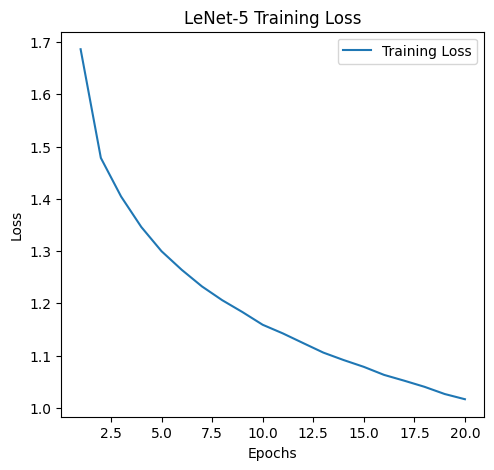

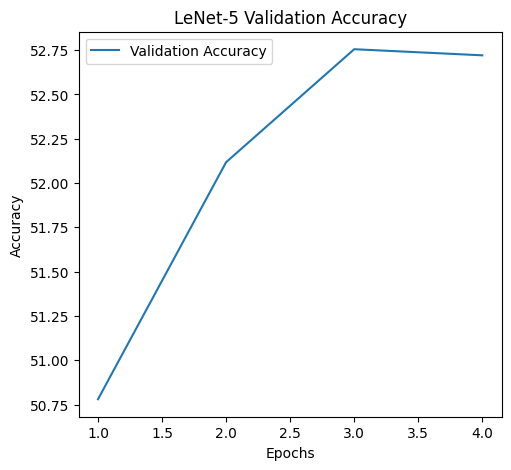

Overall Test Accuracy: 52.64%


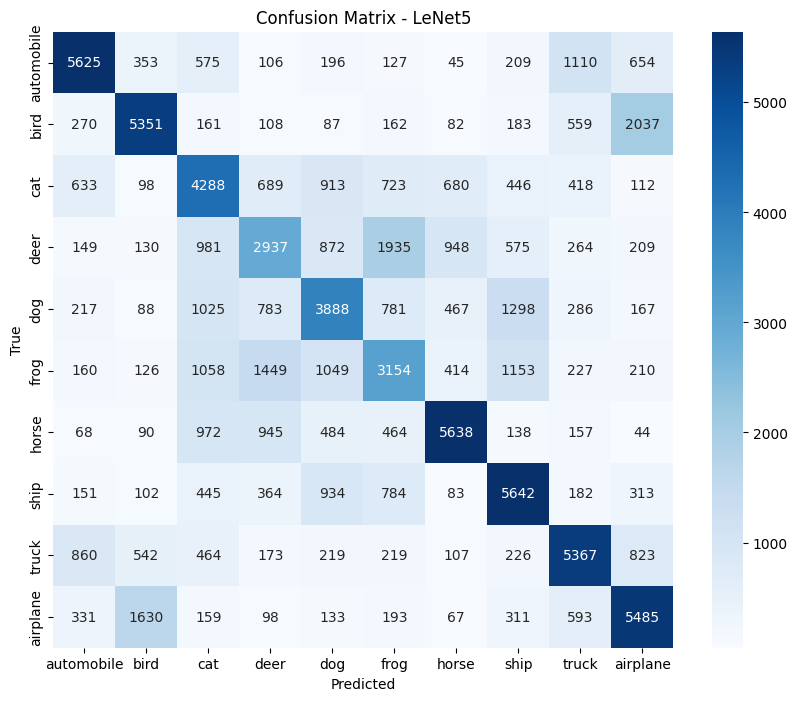

LeNet-5 Test Accuracy: 52.64%


In [ ]:
#@title LeNet-5 Adam
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # First convolutional layer (32x32x3 input, 5x5 kernel, 6 output channels, 28x28x6 output)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # Second convolutional layer (14x14x6 input, 5x5 kernel, 16 output channels, 10x10x16 output)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Third convolutional layer (5x5x16 input, 5x5 kernel, 120 output channels, 1x1x120 output)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)  # 1x1x120 to 84
        self.fc2 = nn.Linear(84, 10)   # 84 to 10 for output classes

    def forward(self, x):
        # First layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Third layer: Conv -> ReLU
        x = F.relu(self.conv3(x))

        # Flatten for fully connected layers
        x = x.view(-1, 120)

        # Fully connected layer 1
        x = F.relu(self.fc1(x))

        # Fully connected layer 2 (output layer)
        x = self.fc2(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet = LeNet5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

lenet_train_losses = []
lenet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(lenet, train_loader, criterion, optimizer_lenet, device)
    lenet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(lenet, valid_loader, criterion, device)
      lenet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(lenet_train_losses, 'LeNet-5')
plot_metrics_validation(lenet_train_losses[::5], lenet_val_accuracies, 'LeNet-5')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(lenet, test_loader, classes, device)
lenet_accuracy = compute_accuracy(lenet, test_loader, device)
print(f"LeNet-5 Test Accuracy: {lenet_accuracy:.2f}%")

Epoch [1/20] - LeNet-5: Training Loss = 1.5798
Epoch [2/20] - LeNet-5: Training Loss = 1.3967
Epoch [3/20] - LeNet-5: Training Loss = 1.3261
Epoch [4/20] - LeNet-5: Training Loss = 1.2783
Epoch [5/20] - LeNet-5: Training Loss = 1.2388, Validation Accuracy = 52.76%
Epoch [6/20] - LeNet-5: Training Loss = 1.2051
Epoch [7/20] - LeNet-5: Training Loss = 1.1782
Epoch [8/20] - LeNet-5: Training Loss = 1.1495
Epoch [9/20] - LeNet-5: Training Loss = 1.1250
Epoch [10/20] - LeNet-5: Training Loss = 1.1010, Validation Accuracy = 54.42%
Epoch [11/20] - LeNet-5: Training Loss = 1.0835
Epoch [12/20] - LeNet-5: Training Loss = 1.0647
Epoch [13/20] - LeNet-5: Training Loss = 1.0493
Epoch [14/20] - LeNet-5: Training Loss = 1.0333
Epoch [15/20] - LeNet-5: Training Loss = 1.0166, Validation Accuracy = 53.96%
Epoch [16/20] - LeNet-5: Training Loss = 1.0014
Epoch [17/20] - LeNet-5: Training Loss = 0.9900
Epoch [18/20] - LeNet-5: Training Loss = 0.9777
Epoch [19/20] - LeNet-5: Training Loss = 0.9649
Epoch [

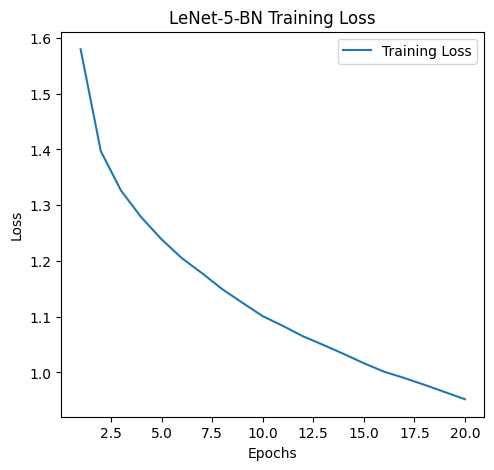

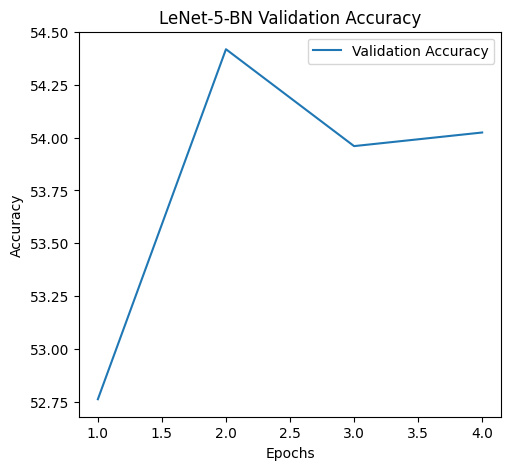

Overall Test Accuracy: 53.78%


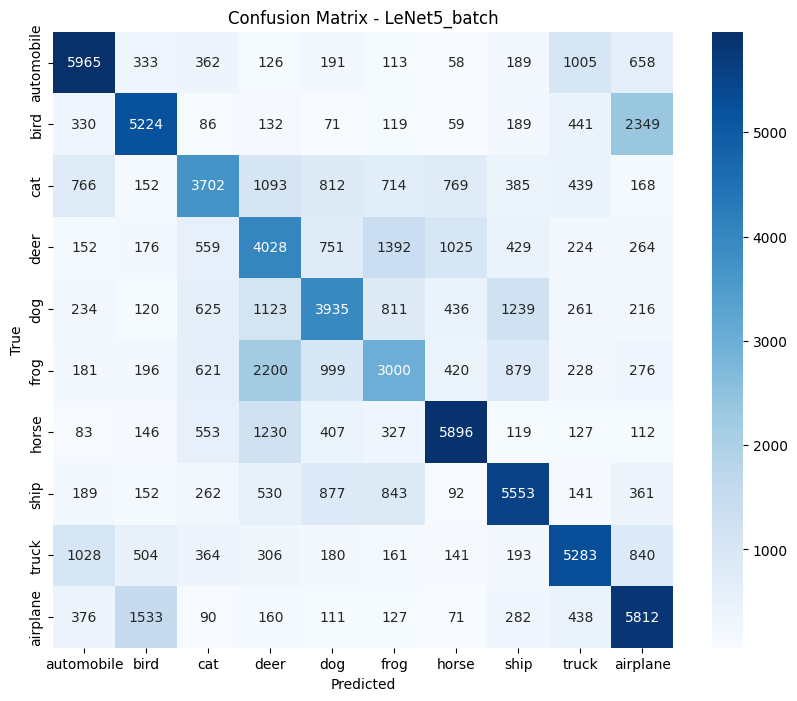

LeNet-5 with batch normalization Test Accuracy: 53.78%


In [ ]:
#@title Lenet5 Batch Normalization
class LeNet5_batch(nn.Module):
    def __init__(self):
        super(LeNet5_batch, self).__init__()

        # First convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)

        # Second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)

        # Third convolutional layer with batch normalization
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(120)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # First layer: Conv -> BatchNorm -> ReLU -> Max Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Second layer: Conv -> BatchNorm -> ReLU -> Max Pool
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Third layer: Conv -> BatchNorm -> ReLU
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(-1, 120)

        # Fully connected layer 1
        x = F.relu(self.fc1(x))

        # Fully connected layer 2 (output layer)
        x = self.fc2(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet = LeNet5_batch().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

lenet_train_losses = []
lenet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(lenet, train_loader, criterion, optimizer_lenet, device)
    lenet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(lenet, valid_loader, criterion, device)
      lenet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(lenet_train_losses, 'LeNet-5-BN')
plot_metrics_validation(lenet_train_losses[::5], lenet_val_accuracies, 'LeNet-5-BN')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(lenet, test_loader, classes, device)
lenet_accuracy = compute_accuracy(lenet, test_loader, device)
print(f"LeNet-5 with batch normalization Test Accuracy: {lenet_accuracy:.2f}%")

Epoch [1/20] - LeNet-5: Training Loss = 1.6939
Epoch [2/20] - LeNet-5: Training Loss = 1.4856
Epoch [3/20] - LeNet-5: Training Loss = 1.4014
Epoch [4/20] - LeNet-5: Training Loss = 1.3476
Epoch [5/20] - LeNet-5: Training Loss = 1.3048, Validation Accuracy = 51.37%
Epoch [6/20] - LeNet-5: Training Loss = 1.2738
Epoch [7/20] - LeNet-5: Training Loss = 1.2448
Epoch [8/20] - LeNet-5: Training Loss = 1.2142
Epoch [9/20] - LeNet-5: Training Loss = 1.1982
Epoch [10/20] - LeNet-5: Training Loss = 1.1746, Validation Accuracy = 53.30%
Epoch [11/20] - LeNet-5: Training Loss = 1.1557
Epoch [12/20] - LeNet-5: Training Loss = 1.1382
Epoch [13/20] - LeNet-5: Training Loss = 1.1223
Epoch [14/20] - LeNet-5: Training Loss = 1.1106
Epoch [15/20] - LeNet-5: Training Loss = 1.0950, Validation Accuracy = 53.05%
Epoch [16/20] - LeNet-5: Training Loss = 1.0849
Epoch [17/20] - LeNet-5: Training Loss = 1.0740
Epoch [18/20] - LeNet-5: Training Loss = 1.0616
Epoch [19/20] - LeNet-5: Training Loss = 1.0521
Epoch [

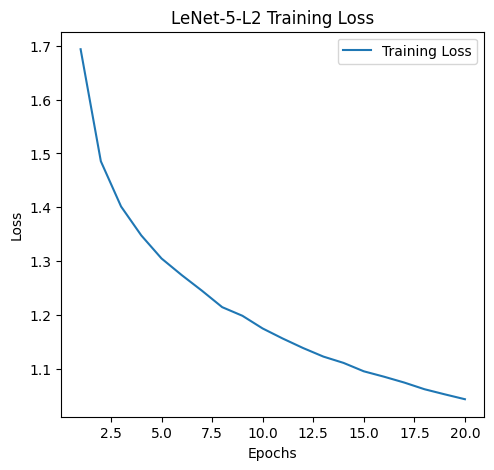

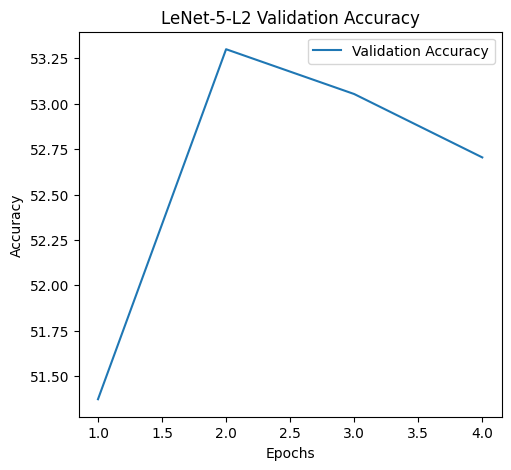

Overall Test Accuracy: 52.86%


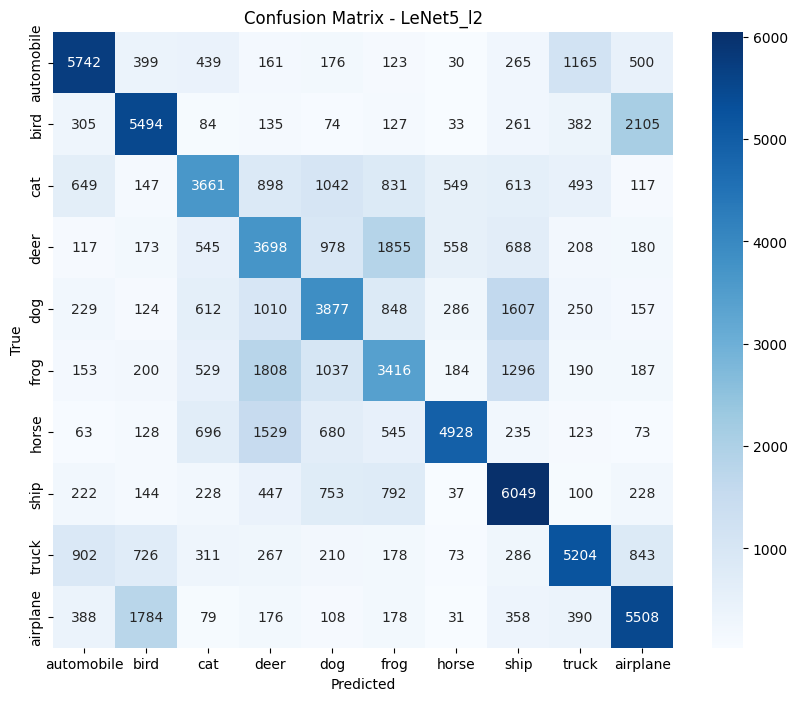

LeNet-5 with L2 regularization Test Accuracy: 52.86%


In [ ]:
#@title Lenet5 L2 regularization

class LeNet5_l2(nn.Module):
    def __init__(self):
        super(LeNet5_l2, self).__init__()

        # First convolutional layer (32x32x3 input, 5x5 kernel, 6 output channels, 28x28x6 output)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # Second convolutional layer (14x14x6 input, 5x5 kernel, 16 output channels, 10x10x16 output)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Third convolutional layer (5x5x16 input, 5x5 kernel, 120 output channels, 1x1x120 output)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)  # 1x1x120 to 84
        self.fc2 = nn.Linear(84, 10)   # 84 to 10 for output classes

    def forward(self, x):
        # First layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Third layer: Conv -> ReLU
        x = F.relu(self.conv3(x))

        # Flatten for fully connected layers
        x = x.view(-1, 120)

        # Fully connected layer 1
        x = F.relu(self.fc1(x))

        # Fully connected layer 2 (output layer)
        x = self.fc2(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet = LeNet5_l2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-6)

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

lenet_train_losses = []
lenet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(lenet, train_loader, criterion, optimizer_lenet, device)
    lenet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(lenet, valid_loader, criterion, device)
      lenet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(lenet_train_losses, 'LeNet-5-L2')
plot_metrics_validation(lenet_train_losses[::5], lenet_val_accuracies, 'LeNet-5-L2')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(lenet, test_loader, classes, device)
lenet_accuracy = compute_accuracy(lenet, test_loader, device)
print(f"LeNet-5 with L2 regularization Test Accuracy: {lenet_accuracy:.2f}%")

Epoch [1/20] - LeNet-5: Training Loss = 2.0932
Epoch [2/20] - LeNet-5: Training Loss = 1.7400
Epoch [3/20] - LeNet-5: Training Loss = 1.6479
Epoch [4/20] - LeNet-5: Training Loss = 1.5821
Epoch [5/20] - LeNet-5: Training Loss = 1.5214, Validation Accuracy = 44.83%
Epoch [6/20] - LeNet-5: Training Loss = 1.4707
Epoch [7/20] - LeNet-5: Training Loss = 1.4303
Epoch [8/20] - LeNet-5: Training Loss = 1.3984
Epoch [9/20] - LeNet-5: Training Loss = 1.3679
Epoch [10/20] - LeNet-5: Training Loss = 1.3419, Validation Accuracy = 50.47%
Epoch [11/20] - LeNet-5: Training Loss = 1.3197
Epoch [12/20] - LeNet-5: Training Loss = 1.2998
Epoch [13/20] - LeNet-5: Training Loss = 1.2823
Epoch [14/20] - LeNet-5: Training Loss = 1.2632
Epoch [15/20] - LeNet-5: Training Loss = 1.2474, Validation Accuracy = 53.19%
Epoch [16/20] - LeNet-5: Training Loss = 1.2326
Epoch [17/20] - LeNet-5: Training Loss = 1.2176
Epoch [18/20] - LeNet-5: Training Loss = 1.2036
Epoch [19/20] - LeNet-5: Training Loss = 1.1878
Epoch [

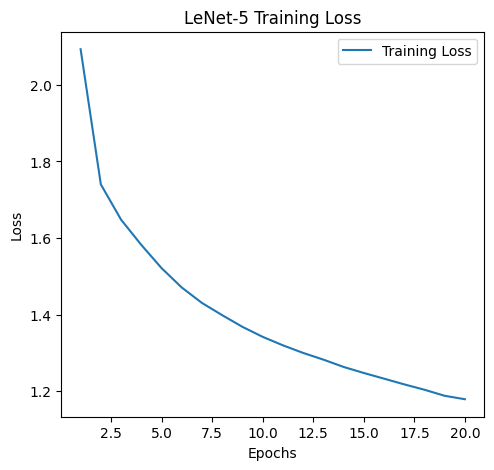

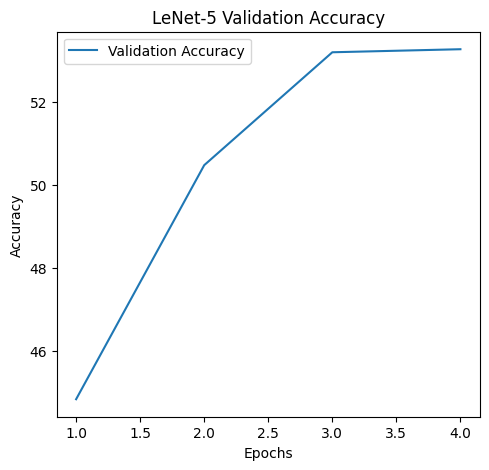

Overall Test Accuracy: 53.12%


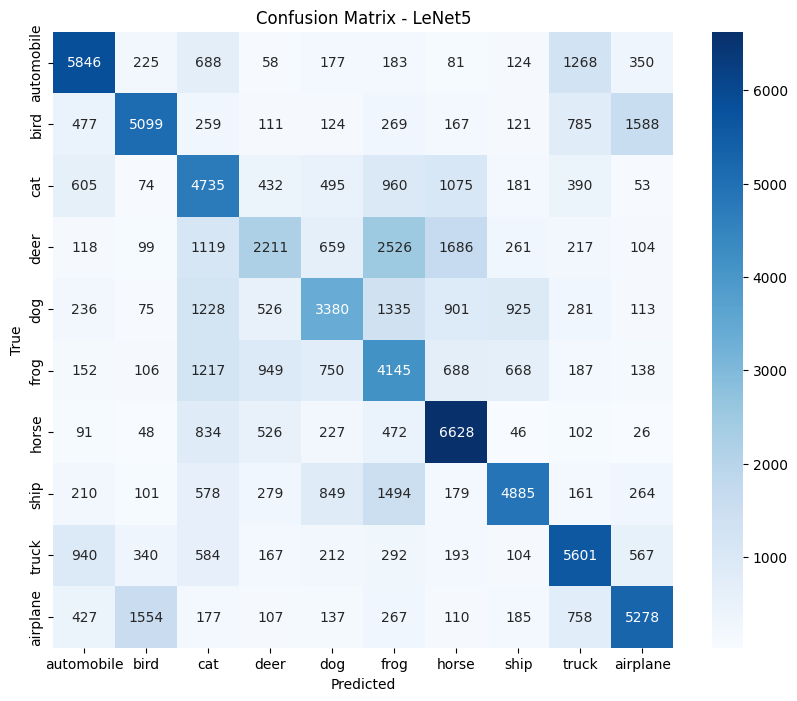

LeNet-5 Test Accuracy: 53.12%


In [ ]:
#@title LeNet-5 SGD

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # First convolutional layer (32x32x3 input, 5x5 kernel, 6 output channels, 28x28x6 output)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # Second convolutional layer (14x14x6 input, 5x5 kernel, 16 output channels, 10x10x16 output)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Third convolutional layer (5x5x16 input, 5x5 kernel, 120 output channels, 1x1x120 output)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)  # 1x1x120 to 84
        self.fc2 = nn.Linear(84, 10)   # 84 to 10 for output classes

    def forward(self, x):
        # First layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Second layer: Conv -> ReLU -> Max Pool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Third layer: Conv -> ReLU
        x = F.relu(self.conv3(x))

        # Flatten for fully connected layers
        x = x.view(-1, 120)

        # Fully connected layer 1
        x = F.relu(self.fc1(x))

        # Fully connected layer 2 (output layer)
        x = self.fc2(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet = LeNet5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

lenet_train_losses = []
lenet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(lenet, train_loader, criterion, optimizer_lenet, device)
    lenet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(lenet, valid_loader, criterion, device)
      lenet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - LeNet-5: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(lenet_train_losses, 'LeNet-5')
plot_metrics_validation(lenet_train_losses[::5], lenet_val_accuracies, 'LeNet-5')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(lenet, test_loader, classes, device)
lenet_accuracy = compute_accuracy(lenet, test_loader, device)
print(f"LeNet-5 Test Accuracy: {lenet_accuracy:.2f}%")

Epoch [1/20] - Resnet-9: Training Loss = 1.3300
Epoch [2/20] - Resnet-9: Training Loss = 0.9698
Epoch [3/20] - Resnet-9: Training Loss = 0.8110
Epoch [4/20] - Resnet-9: Training Loss = 0.6803
Epoch [5/20] - ResNet-9: Training Loss = 0.5690, Validation Accuracy = 72.58%
Epoch [6/20] - Resnet-9: Training Loss = 0.4603
Epoch [7/20] - Resnet-9: Training Loss = 0.3492
Epoch [8/20] - Resnet-9: Training Loss = 0.2522
Epoch [9/20] - Resnet-9: Training Loss = 0.1764
Epoch [10/20] - ResNet-9: Training Loss = 0.1345, Validation Accuracy = 75.91%
Epoch [11/20] - Resnet-9: Training Loss = 0.1053
Epoch [12/20] - Resnet-9: Training Loss = 0.0880
Epoch [13/20] - Resnet-9: Training Loss = 0.0821
Epoch [14/20] - Resnet-9: Training Loss = 0.0696
Epoch [15/20] - ResNet-9: Training Loss = 0.0666, Validation Accuracy = 75.65%
Epoch [16/20] - Resnet-9: Training Loss = 0.0580
Epoch [17/20] - Resnet-9: Training Loss = 0.0548
Epoch [18/20] - Resnet-9: Training Loss = 0.0506
Epoch [19/20] - Resnet-9: Training Lo

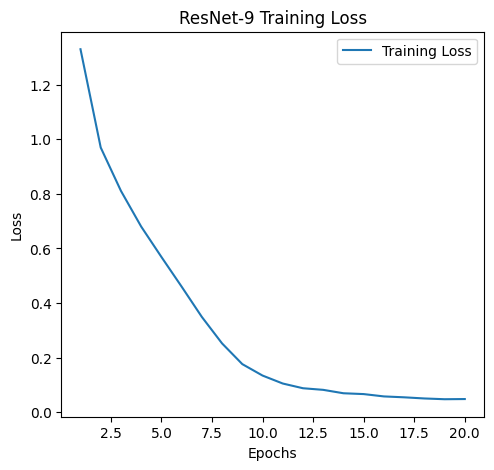

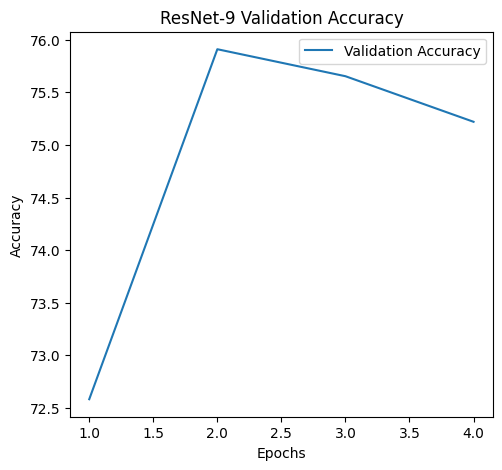

Overall Test Accuracy: 74.93%


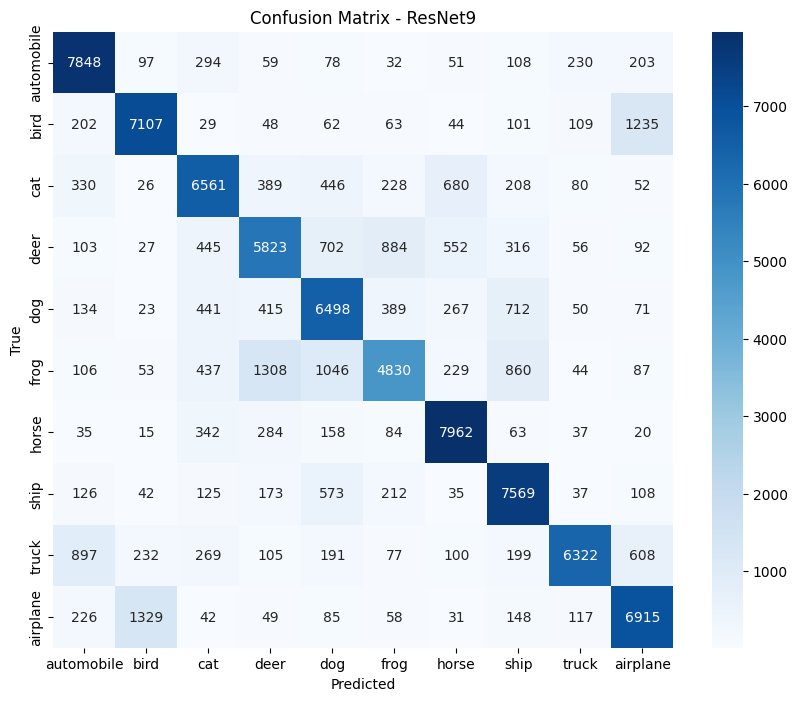

ResNet-9 Test Accuracy: 74.93%


In [ ]:
#@title ResNet9 Adam

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Convolution layers with stride=1 and padding=1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with stride=2
        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )

        # MaxPool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        x = self.skip(x)

        out += x
        out = F.relu(out)

        out = self.pool(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # First residual block
        self.res1 = ResidualBlock(128, 128)

        # Second residual block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third residual block
        self.res2 = ResidualBlock(512, 512)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))  # 32x32 -> 32x32
        x = F.relu(self.bn2(self.conv2(x)))  # 32x32 -> 32x32
        x = self.pool1(x)  # 32x32 -> 16x16

        # First residual block
        x = self.res1(x)  # 16x16 -> 8x8

        # Second residual block
        x = F.relu(self.bn3(self.conv3(x)))  # 8x8 -> 8x8
        x = F.relu(self.bn4(self.conv4(x)))  # 8x8 -> 8x8
        x = self.pool2(x)  # 8x8 -> 4x4

        # Third residual block
        x = self.res2(x)  # 4x4 -> 2x2

        x = self.avgpool(x)  # 2x2 -> 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet9 = ResNet9().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet9.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

resnet_train_losses = []
resnet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(resnet9, train_loader, criterion, optimizer_resnet, device)
    resnet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(resnet9, valid_loader, criterion, device)
      resnet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - ResNet-9: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - Resnet-9: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(resnet_train_losses, 'ResNet-9')
plot_metrics_validation(resnet_train_losses[::5], resnet_val_accuracies, 'ResNet-9')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(resnet9, test_loader, classes, device)
resnet_accuracy = compute_accuracy(resnet9, test_loader, device)
print(f"ResNet-9 Test Accuracy: {resnet_accuracy:.2f}%")

Epoch [1/20] - Resnet-9: Training Loss = 1.3931
Epoch [2/20] - Resnet-9: Training Loss = 1.0479
Epoch [3/20] - Resnet-9: Training Loss = 0.8873
Epoch [4/20] - Resnet-9: Training Loss = 0.7531
Epoch [5/20] - ResNet-9: Training Loss = 0.6305, Validation Accuracy = 65.38%
Epoch [6/20] - Resnet-9: Training Loss = 0.5030
Epoch [7/20] - Resnet-9: Training Loss = 0.3783
Epoch [8/20] - Resnet-9: Training Loss = 0.2666
Epoch [9/20] - Resnet-9: Training Loss = 0.1739
Epoch [10/20] - ResNet-9: Training Loss = 0.1129, Validation Accuracy = 67.07%
Epoch [11/20] - Resnet-9: Training Loss = 0.0686
Epoch [12/20] - Resnet-9: Training Loss = 0.0418
Epoch [13/20] - Resnet-9: Training Loss = 0.0188
Epoch [14/20] - Resnet-9: Training Loss = 0.0074
Epoch [15/20] - ResNet-9: Training Loss = 0.0043, Validation Accuracy = 72.55%
Epoch [16/20] - Resnet-9: Training Loss = 0.0026
Epoch [17/20] - Resnet-9: Training Loss = 0.0022
Epoch [18/20] - Resnet-9: Training Loss = 0.0019
Epoch [19/20] - Resnet-9: Training Lo

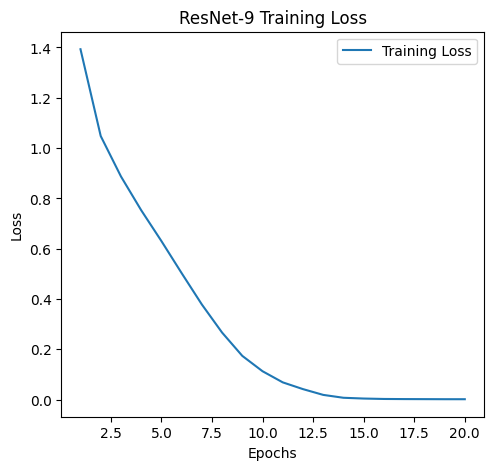

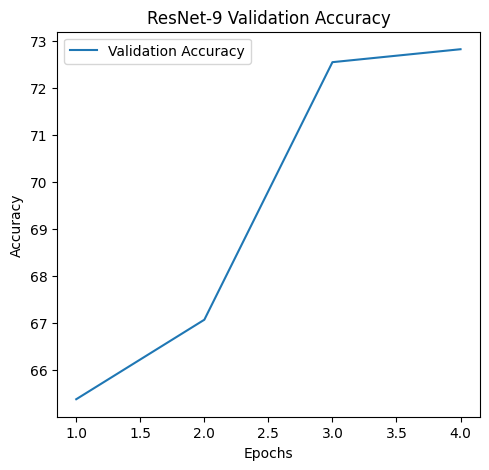

Overall Test Accuracy: 72.64%


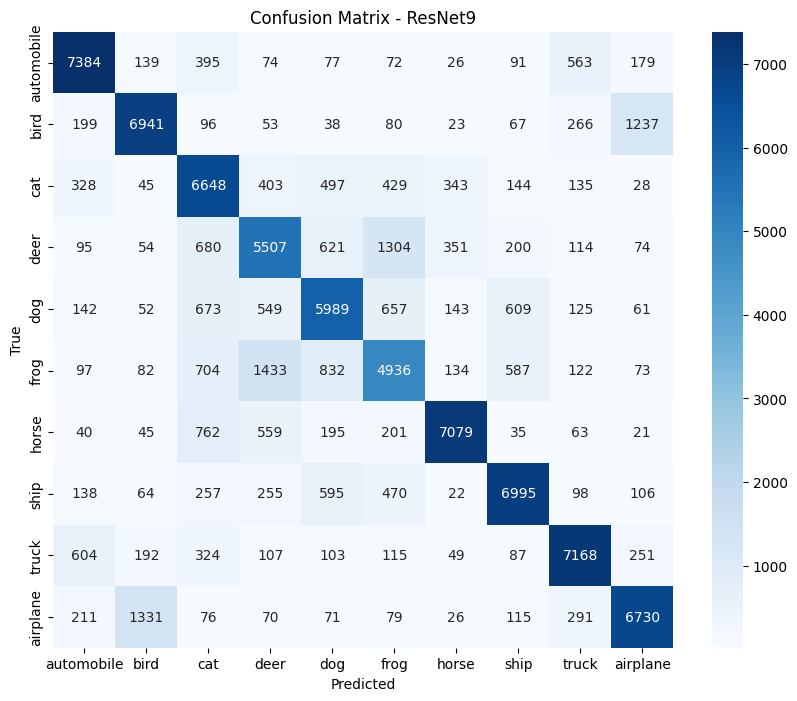

ResNet-9 Test Accuracy: 72.64%


In [ ]:
#@title ResNet9 SGD

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Convolution layers with stride=1 and padding=1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with stride=2
        self.skip = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )

        # MaxPool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        x = self.skip(x)

        out += x
        out = F.relu(out)

        out = self.pool(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # First residual block
        self.res1 = ResidualBlock(128, 128)

        # Second residual block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third residual block
        self.res2 = ResidualBlock(512, 512)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))  # 32x32 -> 32x32
        x = F.relu(self.bn2(self.conv2(x)))  # 32x32 -> 32x32
        x = self.pool1(x)  # 32x32 -> 16x16

        # First residual block
        x = self.res1(x)  # 16x16 -> 8x8

        # Second residual block
        x = F.relu(self.bn3(self.conv3(x)))  # 8x8 -> 8x8
        x = F.relu(self.bn4(self.conv4(x)))  # 8x8 -> 8x8
        x = self.pool2(x)  # 8x8 -> 4x4

        # Third residual block
        x = self.res2(x)  # 4x4 -> 2x2

        x = self.avgpool(x)  # 2x2 -> 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet9 = ResNet9().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(resnet9.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
batch_size = 128

train_loader = dataset.get_train_loader()
valid_loader = dataset.get_valid_loader()
test_loader = dataset.get_test_loader()

resnet_train_losses = []
resnet_val_accuracies = []

# Training loop
for epoch in range(1, num_epochs+1):
    train_loss = train(resnet9, train_loader, criterion, optimizer_resnet, device)
    resnet_train_losses.append(train_loss)
    if epoch % 5 == 0:
      val_loss, val_accuracy = validate(resnet9, valid_loader, criterion, device)
      resnet_val_accuracies.append(val_accuracy)
      print(f"Epoch [{epoch}/{num_epochs}] - ResNet-9: Training Loss = {train_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    else:
      print(f"Epoch [{epoch}/{num_epochs}] - Resnet-9: Training Loss = {train_loss:.4f}")

# Plotting metrics
plot_metrics_train(resnet_train_losses, 'ResNet-9')
plot_metrics_validation(resnet_train_losses[::5], resnet_val_accuracies, 'ResNet-9')
classes = ['automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'airplane']
plot_confusion_matrix(resnet9, test_loader, classes, device)
resnet_accuracy = compute_accuracy(resnet9, test_loader, device)
print(f"ResNet-9 Test Accuracy: {resnet_accuracy:.2f}%")

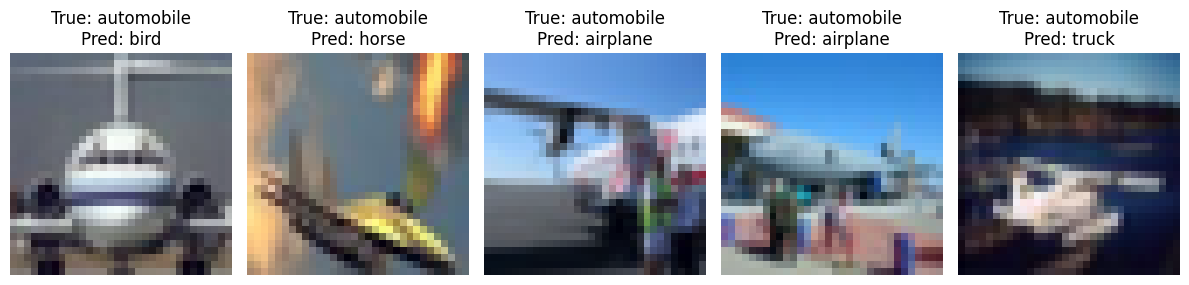

In [ ]:
#@title Display mismatched images

def display_misclassified_images(model, data_loader, classes, device, num_images):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Identify misclassified images
            misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0]
            for idx in misclassified_indices:
                if len(misclassified_images) < num_images:
                    misclassified_images.append(images[idx].cpu())
                    misclassified_labels.append(labels[idx].item())
                    misclassified_preds.append(preds[idx].item())
                else:
                    break

    # Plot the misclassified images
    fig, axes = plt.subplots(1, len(misclassified_images), figsize=(12, 12))
    for i, img in enumerate(misclassified_images):
        ax = axes[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img)
        ax.set_title(f"True: {classes[misclassified_labels[i]]}\nPred: {classes[misclassified_preds[i]]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

display_misclassified_images(resnet9, test_loader, classes, device, num_images=5)